In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

### Load CIFAR-10 data

In [4]:
cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

cifar10_train_data = TVdatasets.CIFAR10(root="./data/", 
                                        train=True, 
                                        download=True, 
                                        transform=cifar10_transform)

cifar10_test_data = TVdatasets.CIFAR10(root="./data/", 
                                       train=False, 
                                       download=True, 
                                       transform=cifar10_transform)

num_train_samples = len(cifar10_train_data)
num_test_samples = len(cifar10_test_data)

print("Number of train samples:", num_train_samples)
print("Number of test samples:", num_test_samples)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

train_batch_size = 32
test_batch_size = 32

trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                         batch_size=train_batch_size,
                                         shuffle=True,
                                         **kwargs)

testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                         batch_size=test_batch_size,
                                         shuffle=False,
                                        **kwargs)

### Model definition

In [6]:
class Holdout(nn.Module):
    def __init__(self):
        super(Holdout, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)    
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out

model = Holdout().to(device)

# model.load_state_dict(torch.load("./checkpoint/holdout.pth"))
# model = model.eval().cuda()

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=10)
fgsm_attack = FGSM(model, eps=8/255)

### Training Process

In [11]:
num_batches = len(cifar10_train_data) // train_batch_size
num_epochs = 5
loss_lst = []

for epoch in range(num_epochs):
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
        
        batch_adv_imgs = pgd_attack(batch_imgs, batch_labels)
        
        X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)   
        Y_train_gt = torch.cat((batch_labels, batch_labels), 0)

#         X_train = batch_imgs
#         Y_train_gt = batch_labels
        
        Y_train_pred = model(X_train)
        loss_val = loss(Y_train_pred, Y_train_gt)
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        if (itr + 1) % 100 == 0:
            print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                        itr+1, num_batches, 
                                                                        round(loss_val.item(),4)))
        
        loss_lst.append(loss_val.item())

model_save_path = './cifar10_net.pth'
torch.save(model.state_dict(), model_save_path)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/5], Iteration [100/1562], Loss:2.0835
Epoch [1/5], Iteration [200/1562], Loss:1.7759
Epoch [1/5], Iteration [300/1562], Loss:1.7474
Epoch [1/5], Iteration [400/1562], Loss:1.5234
Epoch [1/5], Iteration [500/1562], Loss:1.5417
Epoch [1/5], Iteration [600/1562], Loss:1.5558
Epoch [1/5], Iteration [700/1562], Loss:1.7099
Epoch [1/5], Iteration [800/1562], Loss:1.6887
Epoch [1/5], Iteration [900/1562], Loss:1.4756
Epoch [1/5], Iteration [1000/1562], Loss:1.6947
Epoch [1/5], Iteration [1100/1562], Loss:1.4938
Epoch [1/5], Iteration [1200/1562], Loss:1.674
Epoch [1/5], Iteration [1300/1562], Loss:1.45
Epoch [1/5], Iteration [1400/1562], Loss:1.3551
Epoch [1/5], Iteration [1500/1562], Loss:1.3495


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/5], Iteration [100/1562], Loss:1.3645
Epoch [2/5], Iteration [200/1562], Loss:1.4454
Epoch [2/5], Iteration [300/1562], Loss:1.3614
Epoch [2/5], Iteration [400/1562], Loss:1.3305
Epoch [2/5], Iteration [500/1562], Loss:1.6178
Epoch [2/5], Iteration [600/1562], Loss:1.4548
Epoch [2/5], Iteration [700/1562], Loss:1.3775
Epoch [2/5], Iteration [800/1562], Loss:1.5556
Epoch [2/5], Iteration [900/1562], Loss:1.5846
Epoch [2/5], Iteration [1000/1562], Loss:1.279
Epoch [2/5], Iteration [1100/1562], Loss:1.1097
Epoch [2/5], Iteration [1200/1562], Loss:1.6112
Epoch [2/5], Iteration [1300/1562], Loss:1.32
Epoch [2/5], Iteration [1400/1562], Loss:1.5178
Epoch [2/5], Iteration [1500/1562], Loss:1.2391


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/5], Iteration [100/1562], Loss:1.0028
Epoch [3/5], Iteration [200/1562], Loss:1.3801
Epoch [3/5], Iteration [300/1562], Loss:1.4742
Epoch [3/5], Iteration [400/1562], Loss:1.3959
Epoch [3/5], Iteration [500/1562], Loss:1.1894
Epoch [3/5], Iteration [600/1562], Loss:1.5773
Epoch [3/5], Iteration [700/1562], Loss:1.5924
Epoch [3/5], Iteration [800/1562], Loss:1.221
Epoch [3/5], Iteration [900/1562], Loss:1.4747
Epoch [3/5], Iteration [1000/1562], Loss:1.5864
Epoch [3/5], Iteration [1100/1562], Loss:1.1993
Epoch [3/5], Iteration [1200/1562], Loss:1.1838
Epoch [3/5], Iteration [1300/1562], Loss:1.3551
Epoch [3/5], Iteration [1400/1562], Loss:1.3696
Epoch [3/5], Iteration [1500/1562], Loss:1.0917


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/5], Iteration [100/1562], Loss:1.2181
Epoch [4/5], Iteration [200/1562], Loss:0.8677
Epoch [4/5], Iteration [300/1562], Loss:1.2618
Epoch [4/5], Iteration [400/1562], Loss:1.2204
Epoch [4/5], Iteration [500/1562], Loss:1.1484
Epoch [4/5], Iteration [600/1562], Loss:1.547
Epoch [4/5], Iteration [700/1562], Loss:1.5355
Epoch [4/5], Iteration [800/1562], Loss:1.2816
Epoch [4/5], Iteration [900/1562], Loss:1.1415
Epoch [4/5], Iteration [1000/1562], Loss:1.2195
Epoch [4/5], Iteration [1100/1562], Loss:1.0289
Epoch [4/5], Iteration [1200/1562], Loss:1.5429
Epoch [4/5], Iteration [1300/1562], Loss:1.3513
Epoch [4/5], Iteration [1400/1562], Loss:1.1308
Epoch [4/5], Iteration [1500/1562], Loss:1.1051


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/5], Iteration [100/1562], Loss:0.9869
Epoch [5/5], Iteration [200/1562], Loss:1.3419
Epoch [5/5], Iteration [300/1562], Loss:1.1301
Epoch [5/5], Iteration [400/1562], Loss:0.8955
Epoch [5/5], Iteration [500/1562], Loss:1.2394
Epoch [5/5], Iteration [600/1562], Loss:1.0168
Epoch [5/5], Iteration [700/1562], Loss:1.337
Epoch [5/5], Iteration [800/1562], Loss:1.3509
Epoch [5/5], Iteration [900/1562], Loss:1.062
Epoch [5/5], Iteration [1000/1562], Loss:1.6235
Epoch [5/5], Iteration [1100/1562], Loss:1.2882
Epoch [5/5], Iteration [1200/1562], Loss:1.194
Epoch [5/5], Iteration [1300/1562], Loss:1.0386
Epoch [5/5], Iteration [1400/1562], Loss:1.0354
Epoch [5/5], Iteration [1500/1562], Loss:1.4831


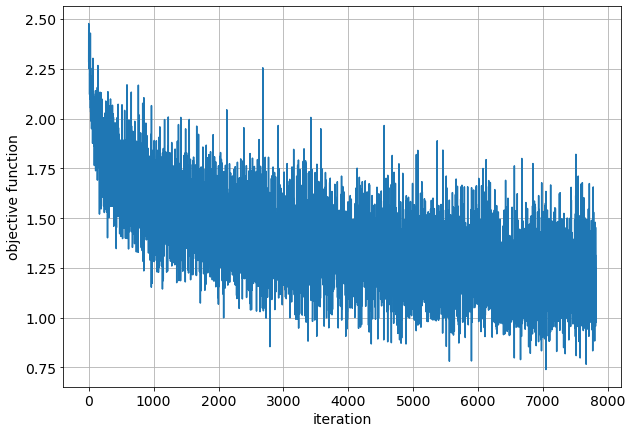

In [12]:
plt.figure(figsize=(10,7))
plt.plot(loss_lst)
plt.xlabel("iteration")
plt.ylabel("objective function")
plt.grid()
plt.show()

In [13]:
# pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=10)
# pgd_attack.set_return_type('int')
# pgd_attack.save(data_loader=testloader, save_path="./data/cifar10_pgd.pt", verbose=True)

In [15]:
# adv_imgs, adv_labels = torch.load("./data/cifar10_pgd.pt")
# adv_data = TensorDataset(adv_imgs.float() / 255.0, adv_labels)
# adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=128, shuffle=False)

### Test accuracy (standard clean)

In [16]:
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
#         print(batch_imgs.shape, batch_labels.shape)

        X_test = batch_imgs
        Y_test_gt = batch_labels

        _, Y_test_pred = torch.max(model(X_test), dim=1)

        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_test_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 69.79 %


### Test accuracy (PGD attack)

In [17]:
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)

    X_test = X_adv_pgd_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_test_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 38.57 %


### Test accuracy (FGSM attack)

In [20]:
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = transforms.functional.rgb_to_grayscale(batch_imgs, num_output_channels=1) 
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)

    X_test = X_adv_fgsm_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_test_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 45.9 %


### Test accuracy (FGSM + PGD attack)

In [21]:
num_corr_pred = 0
model.eval()

fgsm_attack = FGSM(model, eps=0.3)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(0.5 * float(num_corr_pred) / num_test_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 0.2326 %
